In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_19435/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

In [29]:
from helper_funcs.utils import *

tau_1 = get_dt_from(46.2 * ns) * dt
tau_2 = get_dt_from(280 * ns) * dt

tau_3_est_linspace = np.array([55, 75]) * ns
tau_3_est_linspace = convert_arr_to_dt(tau_3_est_linspace)
print(tau_3_est_linspace/ns)

tau_4_est = 40 * ns
tau_4_span = 45 * ns
num_tau_4_exp = 14
tau_4_linspace = np.linspace(-0.5 * tau_4_span + tau_4_est, 0.5 * tau_4_span + tau_4_est, num_tau_4_exp)
tau_4_linspace = convert_arr_to_dt(tau_4_linspace)
print(tau_4_linspace/ns)

freq_span = 4.0 * MHz
freq_center = -1. * MHz
num_freq_exp = 41
ac_freq_linspace = np.linspace(-0.5 * freq_span + freq_center, 0.5 * freq_span + freq_center, num_freq_exp)
print((ac_freq_linspace[1] - ac_freq_linspace[0])/MHz)

[53.33333333 74.66666667]
[17.77777778 21.33333333 24.88888889 28.44444444 32.         35.55555556
 39.11111111 42.66666667 46.22222222 49.77777778 53.33333333 56.88888889
 60.44444444 64.        ]
0.1


In [47]:
comp_vals = np.array(np.meshgrid(tau_3_est_linspace, tau_4_linspace)).reshape(2, -1).T

total_exp = []

for (tau_3, tau_4) in comp_vals:
    tau_3_dt = get_dt_from(tau_3)
    tau_4_dt = get_dt_from(tau_4)

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'AC Stark Photon Meas, tau 3: {int(1e2*tau_3_dt*dt/ns)/1e2}, tau 4: {int(1e2*tau_4_dt*dt/ns)/1e2}, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as ac_freq_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_2 - tau_1), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_3_dt, amp=-1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_4_dt, amp=1.0),
                meas_chan
            )
            pulse.delay(2 * measure_pulse.sigma, qubit_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        total_exp.append(ac_freq_sched)

print(len(total_exp))
acquisition_checker(total_exp)

1148


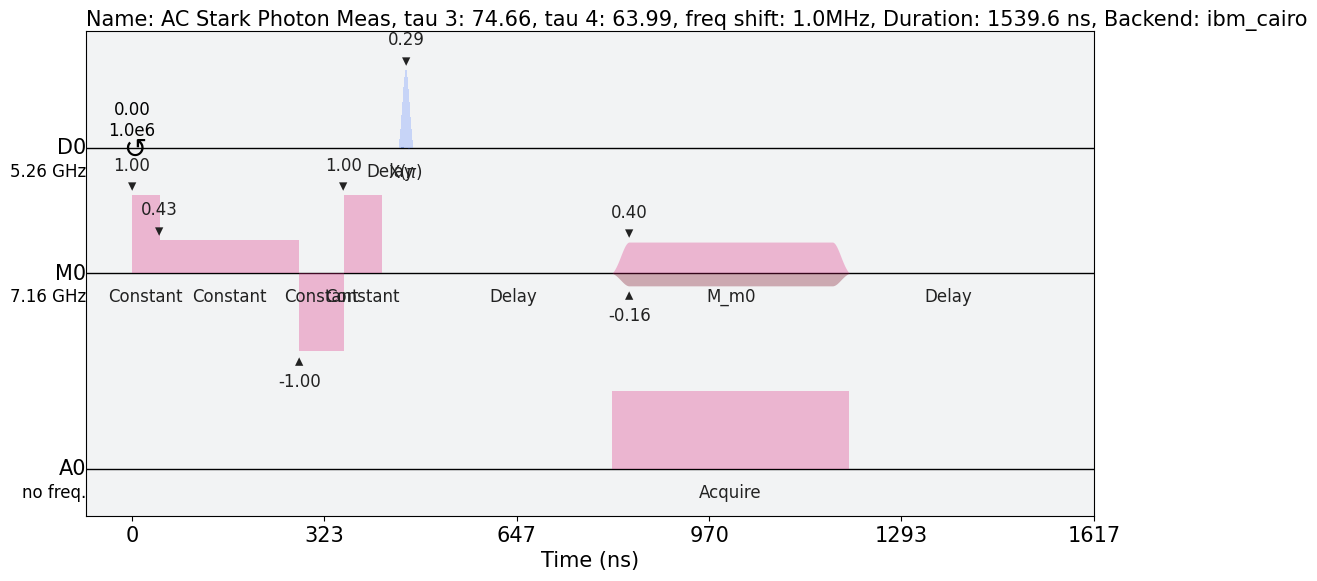

In [48]:
total_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

287


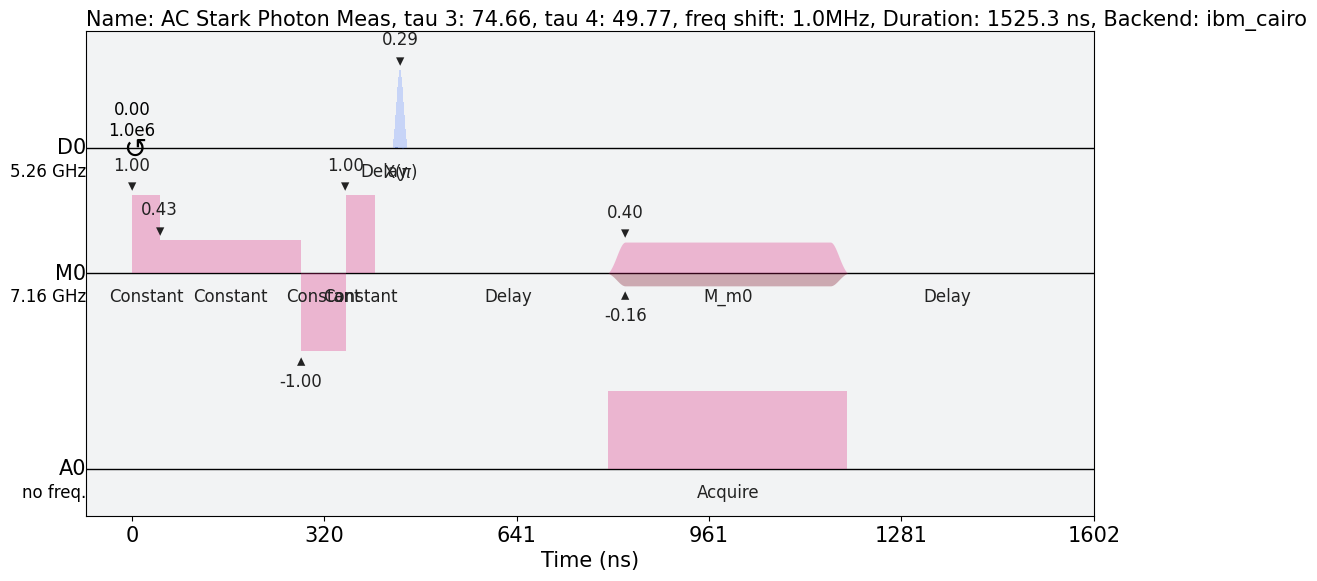

In [52]:
exp_1, exp_2, exp_3, exp_4 = np.array(total_exp).reshape(4, -1).tolist()
print(len(exp_1))
exp_3[-42].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [56]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_experiment = backend.run(exp_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 